# AMICI in pyPESTO

---
---
**After this notebook you can...**
* ...create a pyPESTO problem directly from an AMICI model or through PEtab.
* ...perform parameter estimation of your amici model and adjust advanced settings for this.
* ...evaluate an optimization through basic visualizations.
* ...inspect parameter uncertainties through profile likelihoods and MCMC sampling.

---
---


In order to run optimizations and/or uncertainty analysis, we turn to pyPESTO (**P**arameter **ES**timation **TO**olbox for python).

pyPESTO is python tool for parameter estimation. It provides an interface to the model simulation tool [AMICI](https://github.com/AMICI-dev/AMICI) for the simulation of Ordinary Differential Equation (ODE) models specified in the SBML format. With it we can optimize our model parameters given measurement data, we can do uncertainty analysis via profile likelihoods and/or through sampling methods. pyPESTO provides an interface to many optimizers, global and local, such as e.g. SciPy optimizers, Fides and Pyswarm. Additionally it interfaces samplers such as pymc, emcee and some of its own samplers.

In [1]:
# import
import logging
import tempfile
from pprint import pprint

import amici
import matplotlib as mpl
import numpy as np
import petab
from IPython.display import Markdown, display

import pypesto.optimize as optimize
import pypesto.petab
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
import pypesto.visualize as visualize
import pypesto.visualize.model_fit as model_fit

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 18


# name of the model that will also be the name of the python module
model_name = "boehm_JProteomeRes2014"

# output directory
model_output_dir = "tmp/" + model_name

# 1. Create a pyPESTO problem

## Create a pyPESTO objective from AMICI

Before we can use AMICI to simulate our model, the SBML model needs to be translated to C++ code. This is done by `amici.SbmlImporter`.

In [2]:
sbml_file = f"./{model_name}/{model_name}.xml"
# Create an SbmlImporter instance for our SBML model
sbml_importer = amici.SbmlImporter(sbml_file)

In this example, we want to specify fixed parameters, observables and a $\sigma$ parameter. Unfortunately, the latter two are not part of the [SBML standard](http://sbml.org/). However, they can be provided to `amici.SbmlImporter.sbml2amici` as demonstrated in the following.

### Constant parameters

Constant parameters, i.e. parameters with respect to which no sensitivities are to be computed (these are often parameters specifying a certain experimental condition) are provided as a list of parameter names.

In [3]:
constant_parameters = ["ratio", "specC17"]

### Observables

We used SBML's [`AssignmentRule`](http://sbml.org/Software/libSBML/5.13.0/docs//python-api/classlibsbml_1_1_rule.html) as a non-standard way to specify *Model outputs* within the SBML file. These rules need to be removed prior to the model import (AMICI does at this time not support these rules). This can be easily done using `amici.assignmentRules2observables()`.

In this example, we introduced parameters named `observable_*` as targets of the observable AssignmentRules. Where applicable we have `observable_*_sigma` parameters for $\sigma$ parameters (see below).

In [4]:
# Retrieve model output names and formulae from AssignmentRules and remove the respective rules
observables = amici.assignmentRules2observables(
    sbml_importer.sbml,  # the libsbml model object
    filter_function=lambda variable: variable.getId().startswith("observable_")
    and not variable.getId().endswith("_sigma"),
)
print("Observables:")
pprint(observables)

Observables:
{'observable_pSTAT5A_rel': {'formula': '(100 * pApB + 200 * pApA * specC17) / '
                                       '(pApB + STAT5A * specC17 + 2 * pApA * '
                                       'specC17)',
                            'name': 'observable_pSTAT5A_rel'},
 'observable_pSTAT5B_rel': {'formula': '-(100 * pApB - 200 * pBpB * (specC17 - '
                                       '1)) / (STAT5B * (specC17 - 1) - pApB + '
                                       '2 * pBpB * (specC17 - 1))',
                            'name': 'observable_pSTAT5B_rel'},
 'observable_rSTAT5A_rel': {'formula': '(100 * pApB + 100 * STAT5A * specC17 + '
                                       '200 * pApA * specC17) / (2 * pApB + '
                                       'STAT5A * specC17 + 2 * pApA * specC17 '
                                       '- STAT5B * (specC17 - 1) - 2 * pBpB * '
                                       '(specC17 - 1))',
                            'name': 'observa

### $\sigma$ parameters

To specify measurement noise as a parameter, we simply provide a dictionary with observable names as keys and a list of (preexisting) parameter names as values to indicate which sigma parameter is to be used for which observable.

In [5]:
sigma_vals = ["sd_pSTAT5A_rel", "sd_pSTAT5B_rel", "sd_rSTAT5A_rel"]
observable_names = observables.keys()
sigmas = dict(zip(list(observable_names), sigma_vals))
pprint(sigmas)

{'observable_pSTAT5A_rel': 'sd_pSTAT5A_rel',
 'observable_pSTAT5B_rel': 'sd_pSTAT5B_rel',
 'observable_rSTAT5A_rel': 'sd_rSTAT5A_rel'}


### Generating the module

Now we can generate the python module for our model. `amici.SbmlImporter.sbml2amici` will symbolically derive the sensitivity equations, generate C++ code for model simulation, and assemble the python module.

In [6]:
sbml_importer.sbml2amici(
    model_name,
    model_output_dir,
    verbose=False,
    observables=observables,
    constant_parameters=constant_parameters,
    sigmas=sigmas,
)

### Importing the module and loading the model

If everything went well, we are ready to load the newly generated model:

In [7]:
model_module = amici.import_model_module(model_name, model_output_dir)

Afterwards, we can get an instance of our model from which we can retrieve information such as parameter names:

In [8]:
model = model_module.getModel()

print("Model parameters:", list(model.getParameterIds()))
print("Model outputs:   ", list(model.getObservableIds()))
print("Model states:    ", list(model.getStateIds()))

Model parameters: ['Epo_degradation_BaF3', 'k_exp_hetero', 'k_exp_homo', 'k_imp_hetero', 'k_imp_homo', 'k_phos', 'sd_pSTAT5A_rel', 'sd_pSTAT5B_rel', 'sd_rSTAT5A_rel']
Model outputs:    ['observable_pSTAT5A_rel', 'observable_pSTAT5B_rel', 'observable_rSTAT5A_rel']
Model states:     ['STAT5A', 'STAT5B', 'pApB', 'pApA', 'pBpB', 'nucpApA', 'nucpApB', 'nucpBpB']


### Running simulations and analyzing results

After importing the model, we can run simulations using `amici.runAmiciSimulation`. This requires a `Model` instance and a `Solver` instance. But, in order go gain a value of fit, we also need to provide some data.

In [9]:
# we prepare our data as it is reported in the benchmark collection

# timepoints
timepoints = np.array(
    [
        0.0,
        2.5,
        5.0,
        10.0,
        15.0,
        20.0,
        30.0,
        40.0,
        50.0,
        60.0,
        80.0,
        100.0,
        120.0,
        160.0,
        200.0,
        240.0,
    ]
)

# measurements
meas_pSTAT5A_rel = np.array(
    [
        7.901073,
        66.363494,
        81.171324,
        94.730308,
        95.116483,
        91.441717,
        91.257099,
        93.672298,
        88.754233,
        85.269703,
        81.132395,
        76.135928,
        65.248059,
        42.599659,
        25.157798,
        15.430182,
    ]
)
meas_pSTAT5B_rel = np.array(
    [
        4.596533,
        29.634546,
        46.043806,
        81.974734,
        80.571609,
        79.035720,
        75.672380,
        71.624720,
        69.062863,
        67.147384,
        60.899476,
        54.809258,
        43.981290,
        29.771458,
        20.089017,
        10.961845,
    ]
)
meas_rSTAT5A_rel = np.array(
    [
        14.723168,
        33.762342,
        36.799851,
        49.717602,
        46.928120,
        47.836575,
        46.928727,
        40.597753,
        43.783664,
        44.457388,
        41.327159,
        41.062733,
        39.235830,
        36.619461,
        34.893714,
        32.211077,
    ]
)

In [10]:
benchmark_parameters = np.array(
    [
        -1.568917588,
        -4.999704894,
        -2.209698782,
        -1.786006548,
        4.990114009,
        4.197735488,
        0.585755271,
        0.818982819,
        0.498684404,
    ]
)
# set timepoints for which we want to simulate the model
model.setTimepoints(timepoints)

# set fixed parameters for which we want to simulate the model
model.setFixedParameters(np.array([0.693, 0.107]))

# set parameters to optimal values found in the benchmark collection
model.setParameterScale(amici.ParameterScaling.log10)
model.setParameters(benchmark_parameters)

# Create solver instance
solver = model.getSolver()

# Run simulation using model parameters from the benchmark collection and default solver options
rdata = amici.runAmiciSimulation(model, solver)

In [11]:
# Create edata instance with dimensions and timepoints
edata = amici.ExpData(
    3,  # number of observables
    0,  # number of event outputs
    0,  # maximum number of events
    timepoints,  # timepoints
)
# set observed data
edata.setObservedData(meas_pSTAT5A_rel, 0)
edata.setObservedData(meas_pSTAT5B_rel, 1)
edata.setObservedData(meas_rSTAT5A_rel, 2)

# set standard deviations to optimal values found in the benchmark collection
edata.setObservedDataStdDev(np.array(16 * [10**0.585755271]), 0)
edata.setObservedDataStdDev(np.array(16 * [10**0.818982819]), 1)
edata.setObservedDataStdDev(np.array(16 * [10**0.498684404]), 2)

In [12]:
rdata = amici.runAmiciSimulation(model, solver, edata)

print("Chi2 value reported in benchmark collection: 47.9765479")
print(f"chi2 value using AMICI: {rdata['chi2']}")

Chi2 value reported in benchmark collection: 47.9765479
chi2 value using AMICI: 47.97654319310132


### Creating pyPESTO objective

We are now set up to create our pyPESTO objective. This objective is a vital part of the pyPESTO infrastructure as it provides a blackbox interface to call any predefined objective function with some parameters and evaluate it. We can easily create an AmiciObjective by supplying the model, an amici solver and the data.

Keep in mind, however, that you can use ANY function you would like for this.

In [13]:
# we make some more adjustments to our model and the solver
model.requireSensitivitiesForAllParameters()

solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)


objective = pypesto.AmiciObjective(
    amici_model=model, amici_solver=solver, edatas=[edata], max_sensi_order=1
)

We can now call the objective function directly for any parameter. The value that is put out is the likelihood function. If we want to interact more with the AMICI returns, we can also return this by call and e.g. retrieve the chi2 value.

In [14]:
# the generic objective call  ## Add what we print
print(f"Objective value: {objective(benchmark_parameters)}")
# a call returning the AMICI data as well
obj_call_with_dict = objective(benchmark_parameters, return_dict=True)
print(
    f'Chi^2 value of the same parameters: {obj_call_with_dict["rdatas"][0]["chi2"]}'
)

Objective value: 138.22199735603812
Chi^2 value of the same parameters: 47.97654319310132


Now this makes the whole process already somewhat easier, but still, getting here took us quite some coding and effort. This will only get more complicated, the more complex the model is. Therefore in the next part we will show you how to bypass the tedious lines of code by using PEtab  .

## Create a pyPESTO problem + objective from Petab

### Background on PEtab

<img src="https://github.com/PEtab-dev/PEtab/blob/main/doc/gfx/petab_files.png?raw=true" width="80%" alt="pyPESTO logo"/>

pyPESTO supports the [PEtab](https://github.com/PEtab-dev/PEtab) standard. PEtab is a data format for specifying parameter estimation problems in systems biology.

A PEtab problem consist of an [SBML](https://sbml.org) file, defining the model topology and a set of `.tsv` files, defining experimental conditions, observables, measurements and parameters (and their optimization bounds, scale, priors...). All files, that make up a PEtab problem, can be structured in a `.yaml` file. The `pypesto.Objective` comming from a PEtab problem corresponds to the negative-log-likelihood/negative-log-posterior disrtibution of the parameters.

For more details on PEtab, the interested reader is refered to [PEtab's format definition](https://petab.readthedocs.io/en/latest/documentation_data_format.html), for examples the reader is refered to the [PEtab benchmark collection](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab). The Model from _[Böhm et al. JProteomRes 2014](https://pubs.acs.org/doi/abs/10.1021/pr5006923)_ is part of the benchmark collection and will be used as the running example throughout this notebook.


In [15]:
%%capture
petab_yaml = f"./{model_name}/{model_name}.yaml"

petab_problem = petab.Problem.from_yaml(petab_yaml)
importer = pypesto.petab.PetabImporter(petab_problem)
problem = importer.create_problem()

In [16]:
# Check the dataframes. First the parameter dataframe
petab_problem.parameter_df.head()

,parameterName,parameterScale,lowerBound,upperBound,nominalValue,estimate
parameterId,,,,,,
Epo_degradation_BaF3,"EPO_{degradation,BaF3}",log10,0.00001,100000,0.026983,1
k_exp_hetero,"k_{exp,hetero}",log10,0.00001,100000,0.000010,1
k_exp_homo,"k_{exp,homo}",log10,0.00001,100000,0.006170,1
k_imp_hetero,"k_{imp,hetero}",log10,0.00001,100000,0.016368,1
k_imp_homo,"k_{imp,homo}",log10,0.00001,100000,97749.379402,1


In [17]:
# Check the observable dataframe
petab_problem.observable_df.head()

,observableName,observableFormula,noiseFormula,observableTransformation,noiseDistribution
observableId,,,,,
pSTAT5A_rel,NaN,(100 * pApB + 200 * pApA * specC17) / (pApB + ...,noiseParameter1_pSTAT5A_rel,lin,normal
pSTAT5B_rel,NaN,-(100 * pApB - 200 * pBpB * (specC17 - 1)) / (...,noiseParameter1_pSTAT5B_rel,lin,normal
rSTAT5A_rel,NaN,(100 * pApB + 100 * STAT5A * specC17 + 200 * p...,noiseParameter1_rSTAT5A_rel,lin,normal


In [18]:
# Check the measurement dataframe
petab_problem.measurement_df.head()

,observableId,preequilibrationConditionId,simulationConditionId,measurement,time,observableParameters,noiseParameters,datasetId
0,pSTAT5A_rel,NaN,model1_data1,7.901073,0.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
1,pSTAT5A_rel,NaN,model1_data1,66.363494,2.5,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
2,pSTAT5A_rel,NaN,model1_data1,81.171324,5.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
3,pSTAT5A_rel,NaN,model1_data1,94.730308,10.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
4,pSTAT5A_rel,NaN,model1_data1,95.116483,15.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel


In [19]:
# check the condition dataframe
petab_problem.condition_df.head()

,conditionName
conditionId,
model1_data1,condition1


This was really straightforward. With this we are still able to do all the same things we did before and also adjust solver setting, change the model etc.

In [20]:
# call the objective function  ## fval=
print(f"Objective value: {problem.objective(benchmark_parameters)}")
# change things in the model
problem.objective.amici_model.requireSensitivitiesForAllParameters()
# change solver settings
print(
    f"Absolute tolerance before change: {problem.objective.amici_solver.getAbsoluteTolerance()}"
)
problem.objective.amici_solver.setAbsoluteTolerance(1e-15)
print(
    f"Absolute tolerance after change: {problem.objective.amici_solver.getAbsoluteTolerance()}"
)

Objective value: 138.22199736863757
Absolute tolerance before change: 1e-16
Absolute tolerance after change: 1e-15


Now we are good to go and start the first optimization.

# Optimization

Once setup, the optimization can be done very quickly with default settings. If needed these settings can be highly individualized and change according to the needs of our model. In this section we shall go over some of these settings.

## Optimizer

The optimizer determines the algorithm with which we optimize our model. The main disjunction is between global and local optimizers.

pyPESTO provides an interface to many optimizers, such as Fides, ScipyOptimizers, Pyswarm and many more. For a whole list of supported optimizers with settings for each optimizer you can [have a look here](https://pypesto.readthedocs.io/en/latest/api.html#optimize).

In [21]:
optimizer_options = {'maxiter': 1e4, 'fatol': 1e-12, 'frtol': 1e-12}

optimizer = optimize.FidesOptimizer(
    options=optimizer_options, verbose=logging.WARN
)

## Startpoint method

The startpoint methods describes how you want to choose your starpoints, in case you do a multistart opimization. The default here is `uniform` meaning that each startpoint is a uniform sample from the allowed parameter space. The other two notable options are either `latin_hypercube` or a self defined function.

In [22]:
startpoint_method = pypesto.startpoint.uniform

## History options

In some cases, it is good to trace what the optimizer did in each step, i.e. the history. There is a multitude of options on what to report here, but the most important one is `trace_record` which turns the history function on and off.

In [23]:
# save optimizer trace
history_options = pypesto.HistoryOptions(trace_record=True)

## Optimization options

Some further possible options for the optimization. Notably `allow_failed_starts`, which in case of a very complicated objective function, can help get to the desired number of optimizations when turned of. As we do not need this here, we create the default options.

In [24]:
opt_options = optimize.OptimizeOptions()
opt_options

{'allow_failed_starts': True,
 'report_sres': True,
 'report_hess': True,
 'history_beats_optimizer': True}

## Running the optimization

We now only need to decide on the number of starts as well as the engine we want to use for the optimization.

In [25]:
n_starts = 100
engine = pypesto.engine.MultiProcessEngine()

Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.


In [26]:
result = optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=n_starts,
    startpoint_method=startpoint_method,
    engine=engine,
    options=opt_options,
)

Performing parallel task execution on 8 processes.
 16%|█▌        | 16/100 [00:00<00:00, 146.62it/s]2023-04-28 11:06:54.081 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 102.841 and h = 1.33409e-05, the error test failed repeatedly or with |h| = hmin. 
2023-04-28 11:06:54.081 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 102.841: AMICI failed to integrate the forward problem
2023-04-28 11:06:54.384 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 91.7986 and h = 2.89534e-05, the error test failed repeatedly or with |h| = hmin. 
2023-04-28 11:06:54.384 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 91.7986: AMICI failed to integrate the forward problem
2023-04-28 11:06:54.385 - amici.swig_wrappers - DEBUG - [model

Now as a first step after the optimization, we can take a look at the summary of the optimizer:

In [27]:
display(Markdown(result.summary()))

## Optimization Result 

* number of starts: 100 
* best value: 138.2220375244485, id=12
* worst value: 249.7459974768038, id=11
* number of non-finite values: 0

* execution time summary:
	* Mean execution time: 3.323s
	* Maximum execution time: 11.284s,	id=27
	* Minimum execution time: 0.532s,	id=91
* summary of optimizer messages:

  |   Count | Message                                  |
  |--------:|:-----------------------------------------|
  |      88 | Trust Region Radius too small to proceed |
  |      12 | Converged according to fval difference   |

* best value found (approximately) 2 time(s)
* number of plateaus found: 7

A summary of the best run:

### Optimizer Result

* optimizer used: <FidesOptimizer  hessian_update=default verbose=30 options={'maxiter': 10000.0, 'fatol': 1e-12, 'frtol': 1e-12}>
* message: Trust Region Radius too small to proceed 
* number of evaluations: 229
* time taken to optimize: 8.661s
* startpoint: [ 3.34776195 -2.51537104 -1.24538289 -3.40305859 -3.57984603  4.14289571
 -3.19165311 -2.2042236   0.52822258]
* endpoint: [-1.56906191 -4.99884826 -2.20981928 -1.78590692  4.99995309  4.1977125
  0.58568456  0.81883723  0.4985834 ]
* final objective value: 138.2220375244485
* final gradient value: [ 3.24754509e-03  5.54998002e-02  1.08245982e-03  4.78148964e-03
 -4.41688771e-05 -1.07241052e-03  2.60104989e-04 -2.05095942e-04
 -6.25787522e-05]
* final hessian value: [[ 2.11217298e+03  5.90499501e-01  1.07056235e+02  2.81535756e+03
   8.80396928e-06 -7.86466497e+02  1.02529565e+02 -8.02215931e+01
  -2.23154496e+01]
 [ 5.90499501e-01  1.92433417e-03 -1.73246783e-01  7.14023759e-01
  -3.62254917e-08 -3.21310854e-01 -1.49054860e-02 -5.69740123e-02
  -5.59135142e-02]
 [ 1.07056235e+02 -1.73246783e-01  7.00027417e+01  1.61439070e+02
   7.00686416e-06 -8.83596352e+01 -3.50367800e+00 -3.02860186e+00
   6.52978740e+00]
 [ 2.81535756e+03  7.14023759e-01  1.61439070e+02  3.76243895e+03
   8.29367215e-06 -1.04206140e+03  1.32824560e+02 -1.05776121e+02
  -2.70594491e+01]
 [ 8.80396928e-06 -3.62254917e-08  7.00686416e-06  8.29367215e-06
   2.73929047e-10 -2.20045283e-04  4.21567208e-05  5.31662591e-05
   6.37961810e-06]
 [-7.86466497e+02 -3.21310854e-01 -8.83596352e+01 -1.04206140e+03
  -2.20045283e-04  9.30434634e+02 -8.20761843e+01  4.93144186e+01
   3.27642349e+01]
 [ 1.02529565e+02 -1.49054860e-02 -3.50367800e+00  1.32824560e+02
   4.21567208e-05 -8.20761843e+01  8.48297709e+01  0.00000000e+00
   0.00000000e+00]
 [-8.02215931e+01 -5.69740123e-02 -3.02860186e+00 -1.05776121e+02
   5.31662591e-05  4.93144186e+01  0.00000000e+00  8.48308420e+01
   0.00000000e+00]
 [-2.23154496e+01 -5.59135142e-02  6.52978740e+00 -2.70594491e+01
   6.37961810e-06  3.27642349e+01  0.00000000e+00  0.00000000e+00
   8.48305139e+01]]


We can see some informative statistics, such as the mean execution time, best and worst values, a small table on the exit messages of the optimizer as well as detailed info on the best optimizer.

As our best start is just as good as the reported benchmark value, we shall now further inspect the result thorough some useful visualisations.

# Optimization visualization

## Model fit

Probably the most useful visualization there is, is one, where we visualize the found parameter dynamics against the measurements. This way we can see whether the fit is qualitatively and/or quantitatively good.

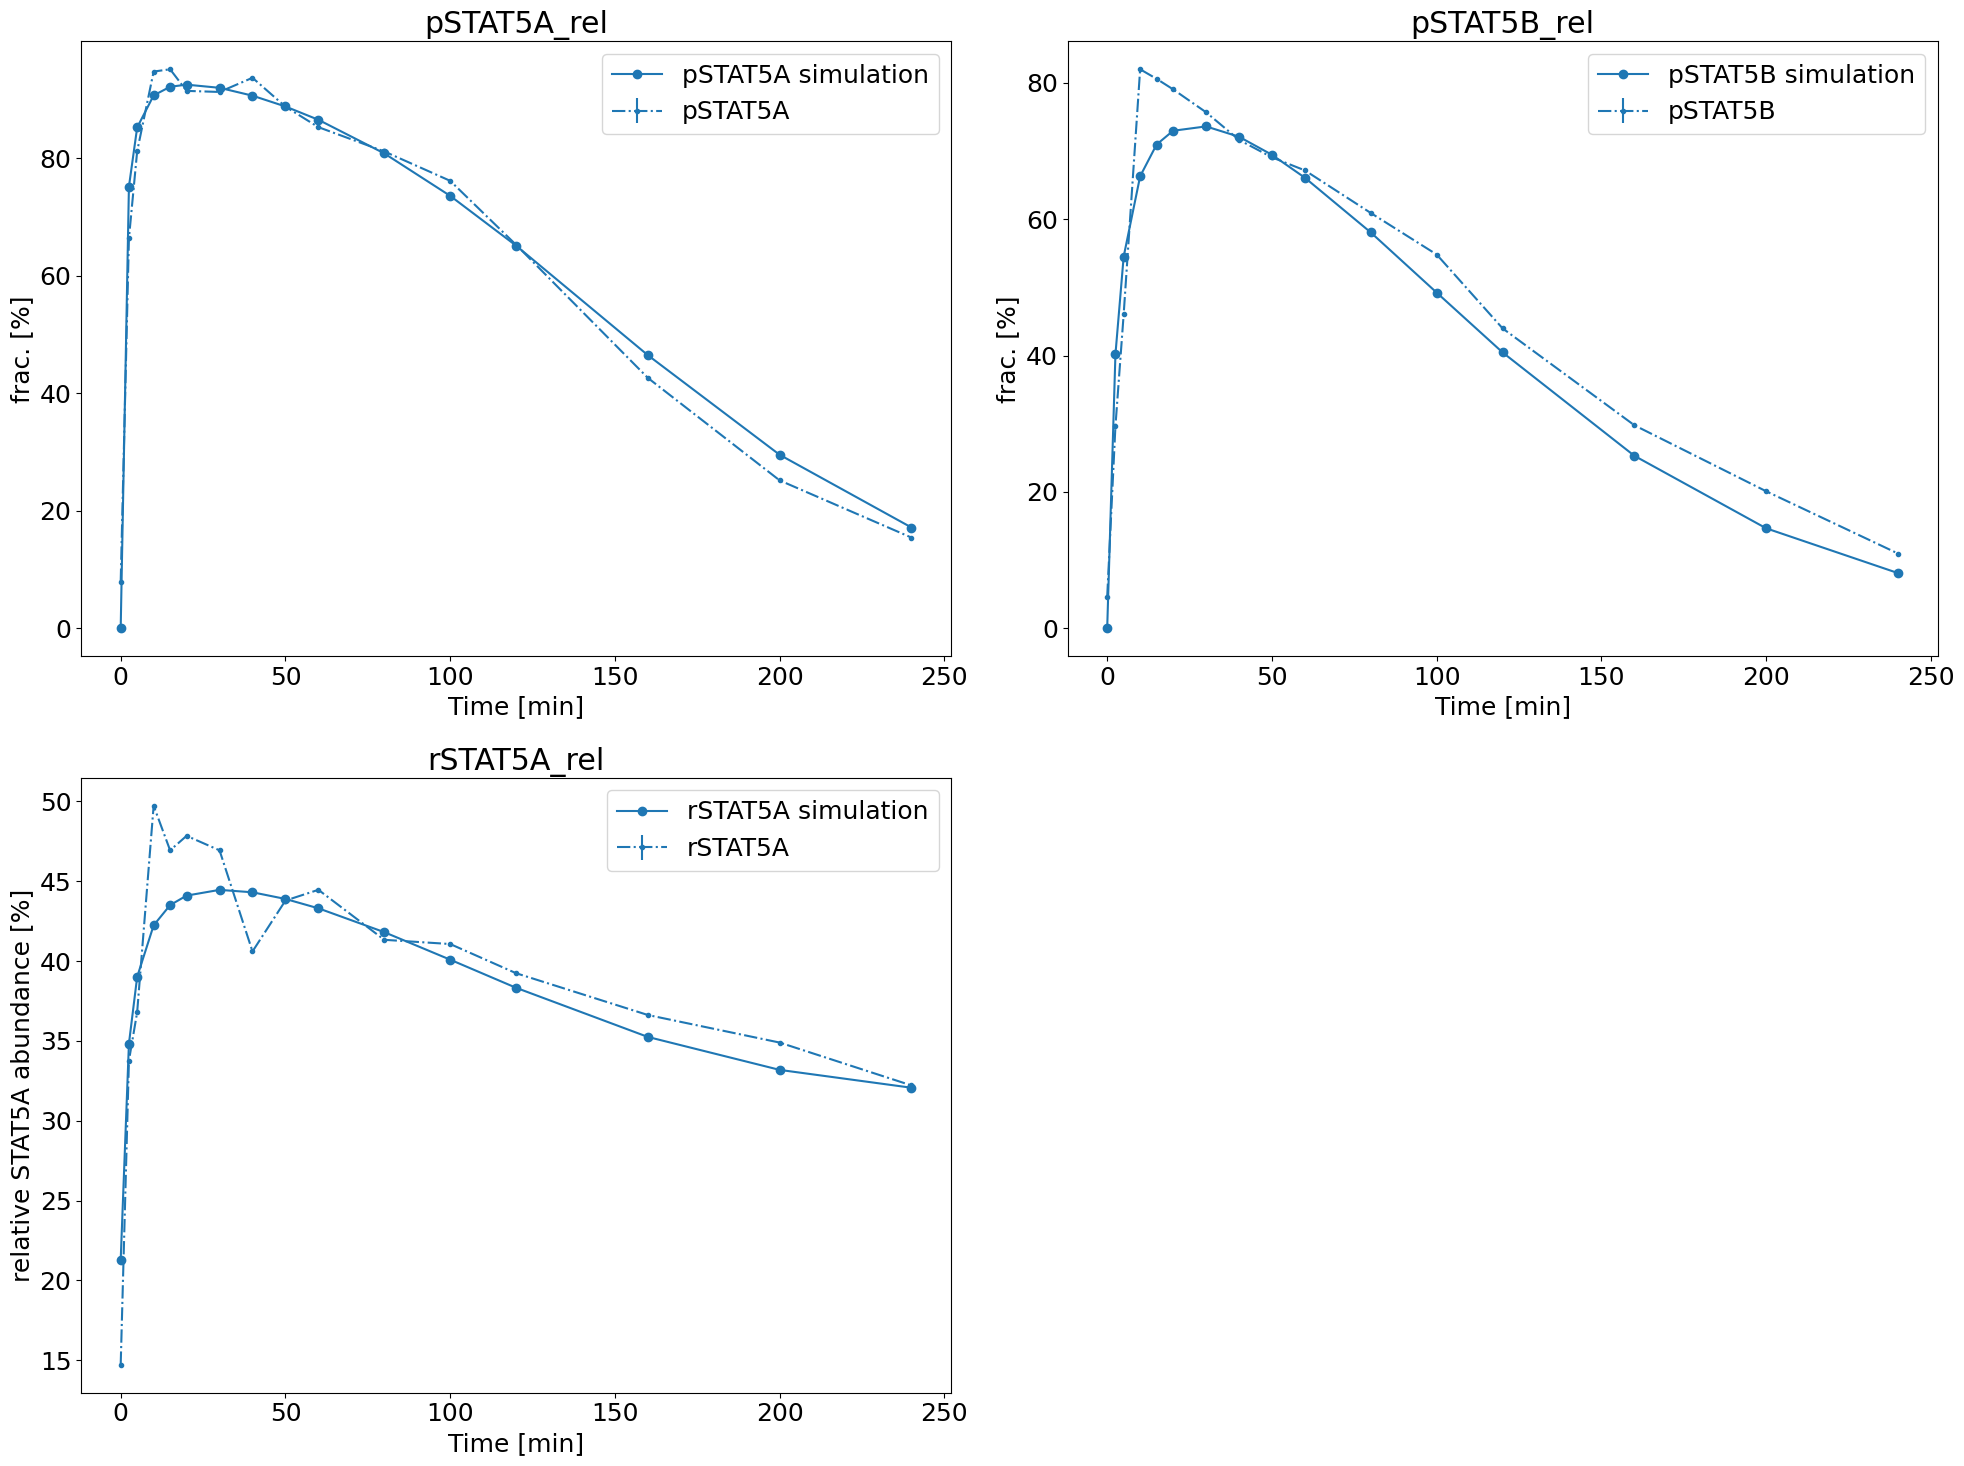

In [28]:
ax = model_fit.visualize_optimized_model_fit(
    petab_problem=petab_problem, result=result, pypesto_problem=problem
)

## Waterfall plot

The waterfall plot is a visualization of the final objective function values of each start. They are sorted from small to high and then plotted. Similar values will get clustered and get the same color.

This helps determining whether the result is reproducible and whether we reliably found a local minimum that we hope to be the golbal one.

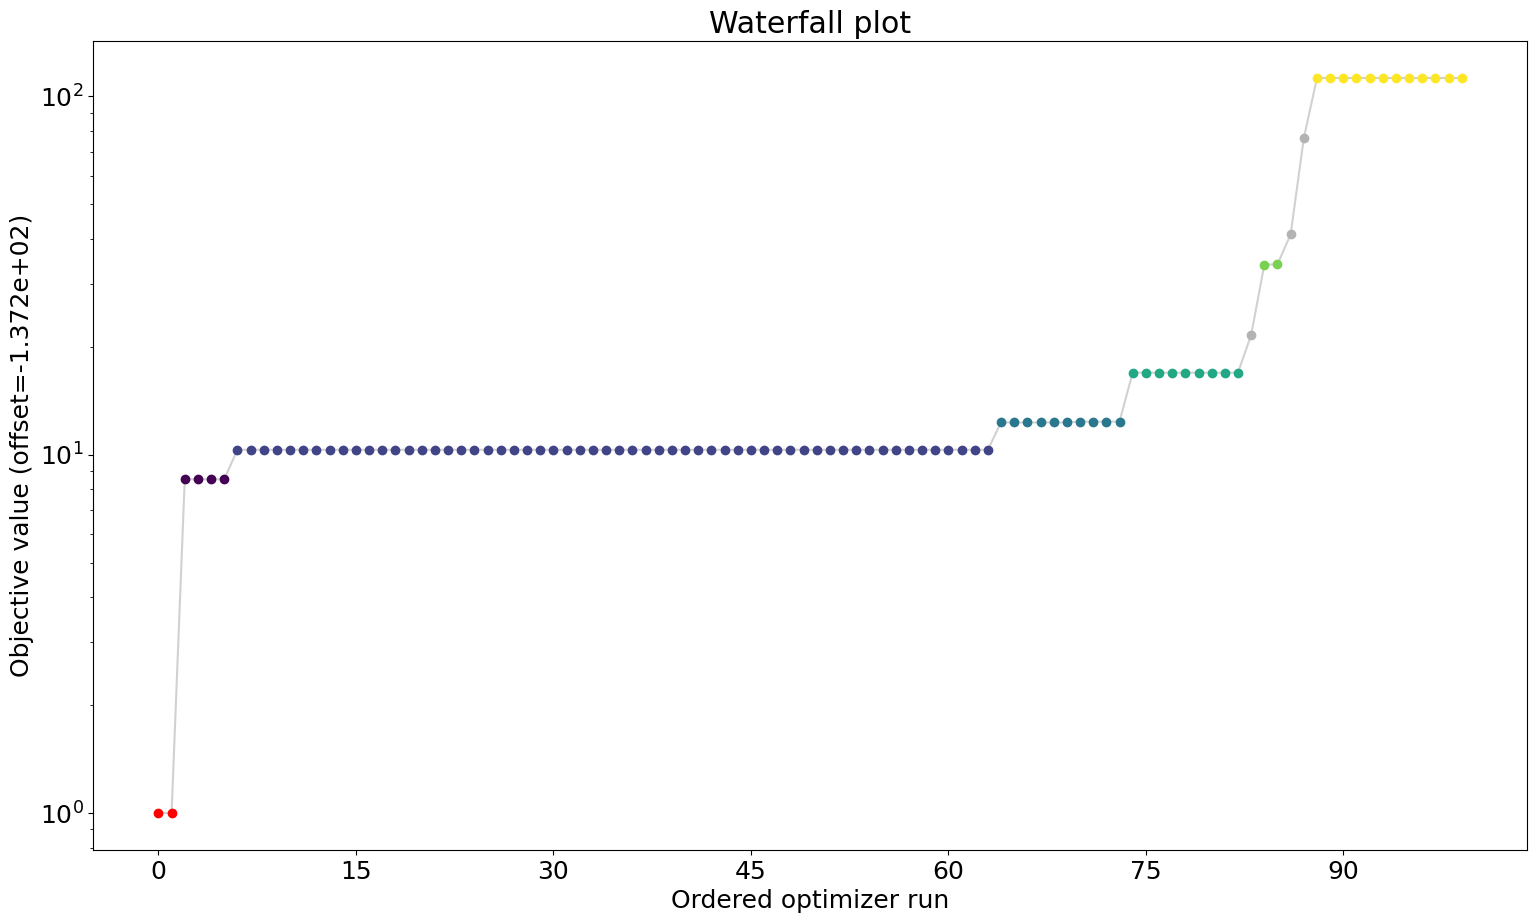

In [29]:
visualize.waterfall(result);

## Parameter plots

To visualize the parameters, there is a multitude of options:

### Parameter overview

Here we plot the parameters of all starts within their bounds. This can tell us whether some bounds are always hit and might need to be questioned and if the best starts are similar or differ amongst themselves, hinting already for some unidentifiabilities.

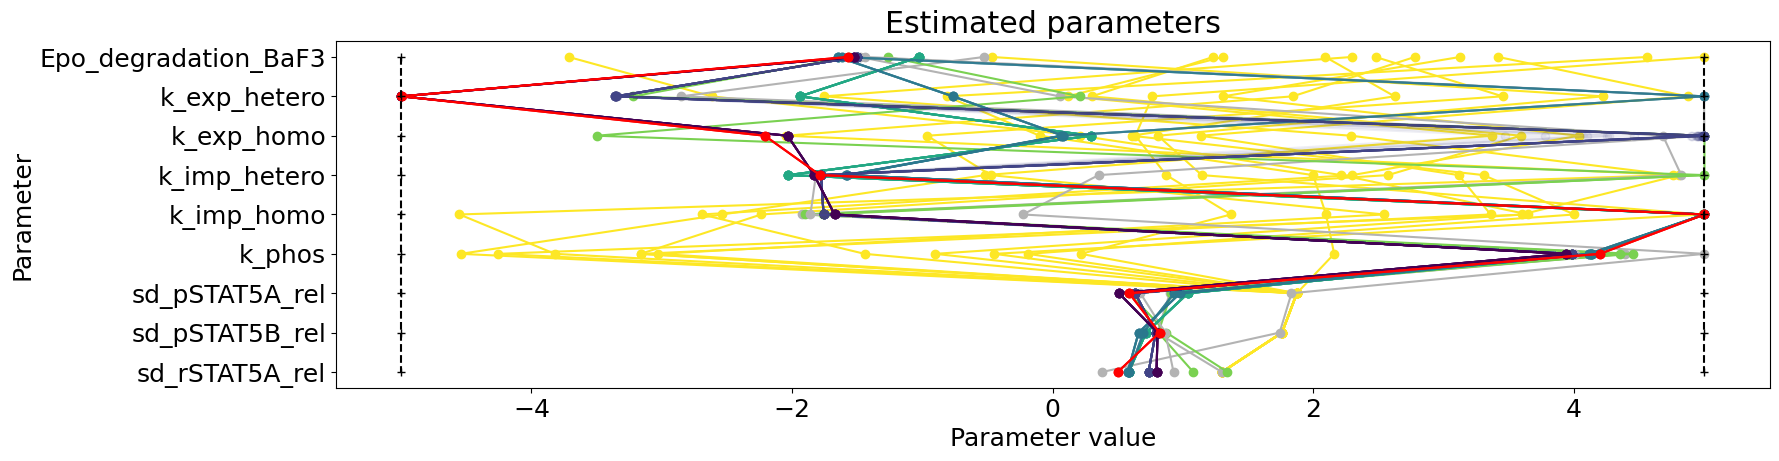

In [30]:
visualize.parameters(result);

### Parameter correlation plot

To further look into possible uncertainties, we can plot the correlation of the final points. Sometimes, pairs of parameters are dependent on each other and fixing one might solve some unidentifiability.

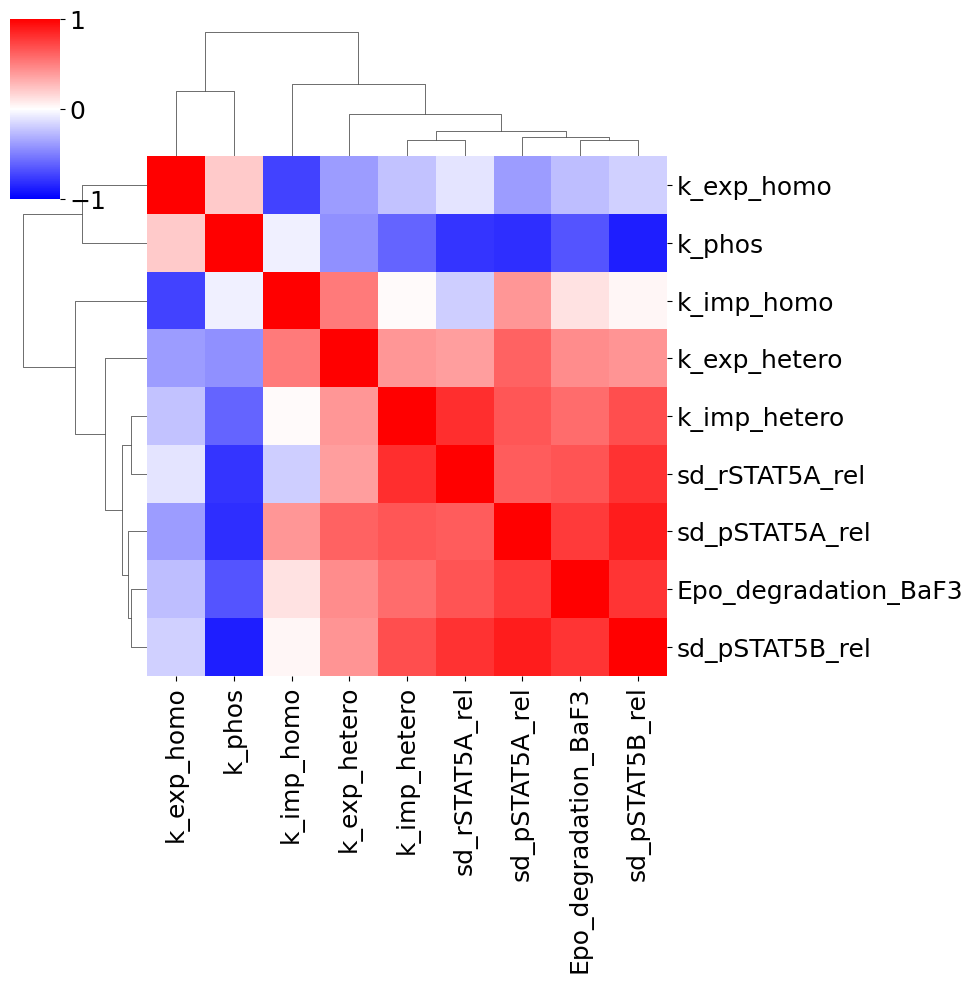

In [31]:
visualize.parameters_correlation_matrix(result);

### Parameter histogram + scatter

In case we found some dependencies and for further investigation, can also specifically look at the histograms of certain parameters and the pairwise parameter scatter plot.

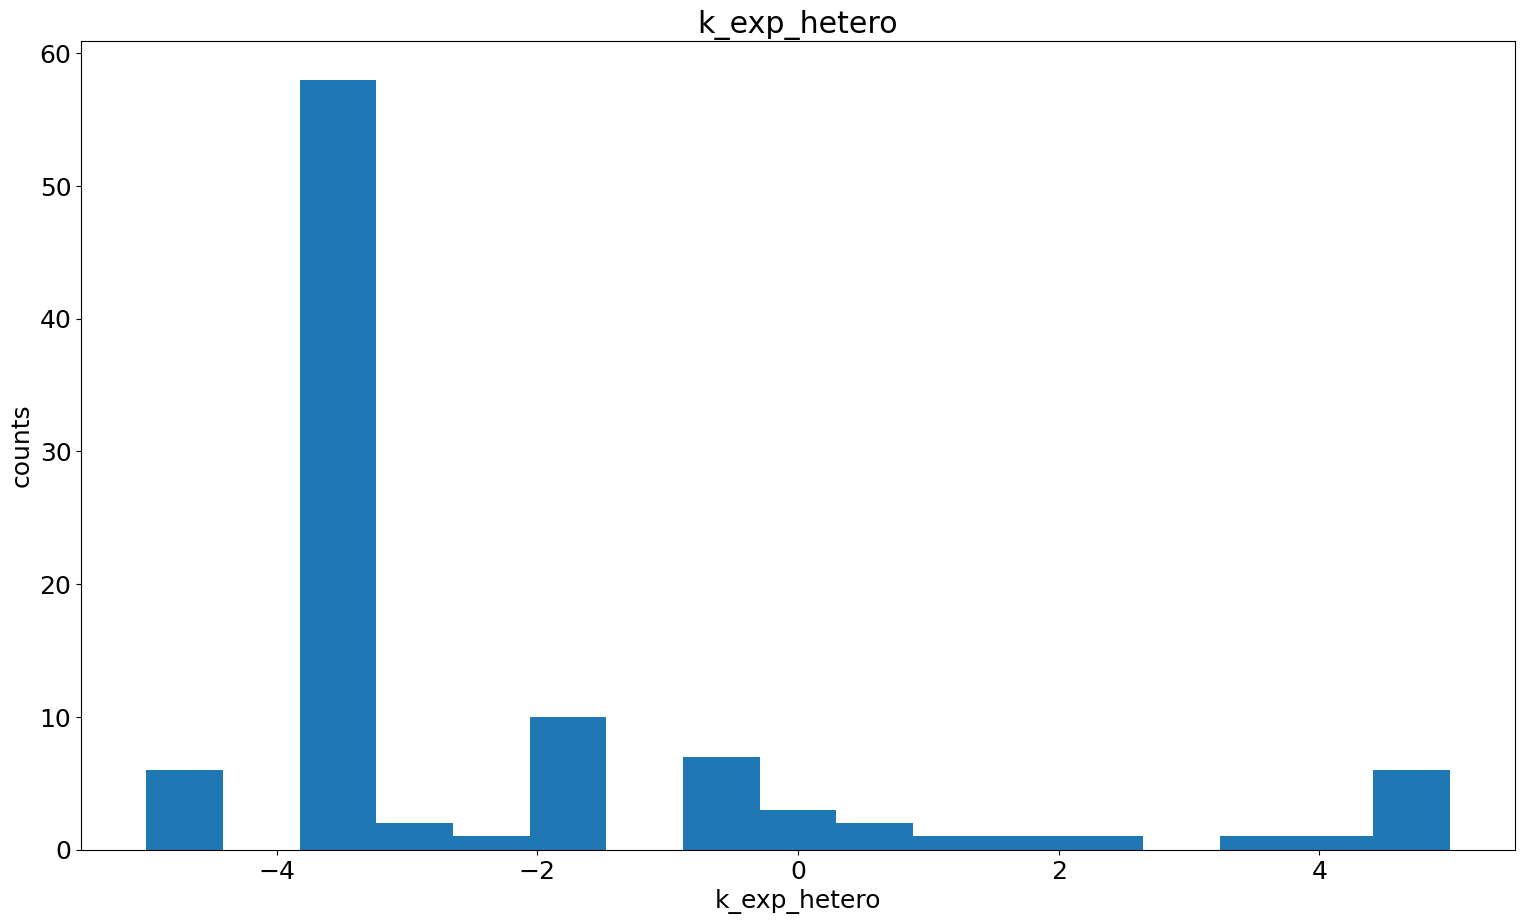

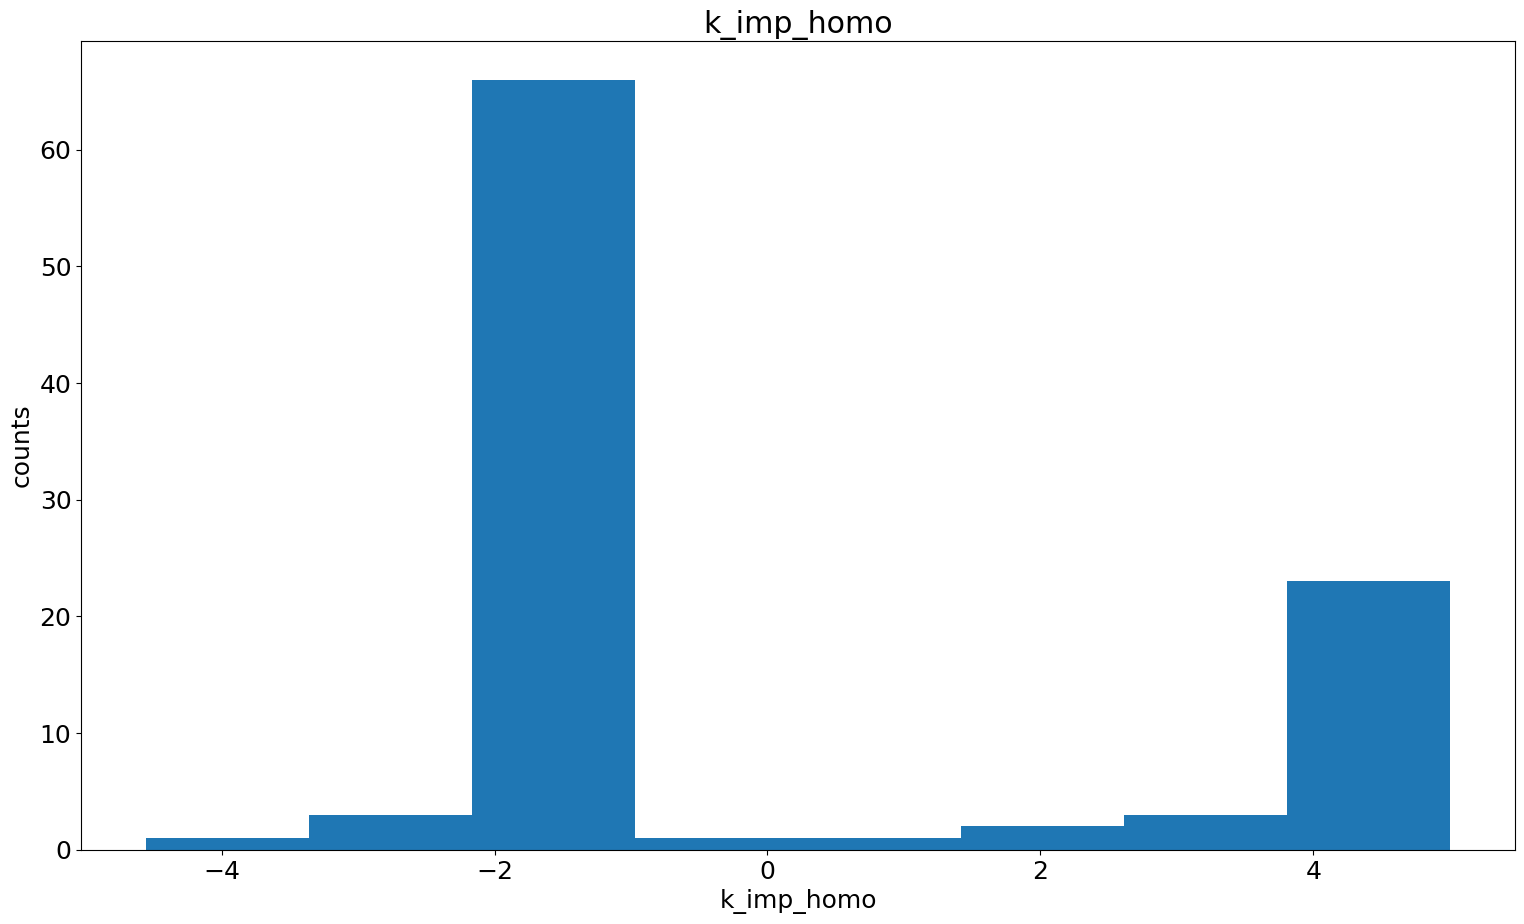

In [32]:
visualize.parameter_hist(result=result, parameter_name="k_exp_hetero")
visualize.parameter_hist(result=result, parameter_name="k_imp_homo");

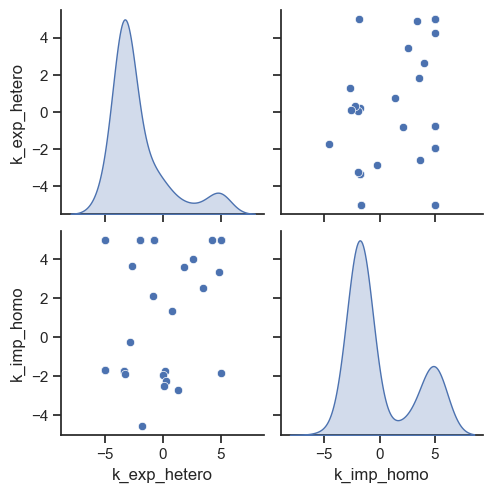

In [33]:
visualize.optimization_scatter(result, parameter_indices=[1, 4]);

We definitely need to look further into it, and thus we turn to uncertainty quantification in next next section.

# Uncertainty quantification

This mainly consists of two parts:
* Profile Liklihoods
* MCMC sampling

## Profile likelihood

The profile likelihood uses an optimization scheme to calculate the confidence intervals for each parameter. We start with the best found parameterset of the optimization. Then in each step, we increase/decrease the parameter of interest, fix it and then run one local optimization. We do this until we either hit the bounds or reach a sufficiently bad fit.

To run the profiling we do not need a lot of setup, as we did this already for the optimization.

In [34]:
result = profile.parameter_profile(
    problem=problem,
    result=result,
    optimizer=optimizer,
    engine=engine,
    profile_index=[0, 1, 3, 4],
)

Performing parallel task execution on 4 processes.
100%|██████████| 4/4 [00:00<00:00, 48.05it/s]
2023-04-28 11:07:48 fides(WARNING) Stopping as trust region radius 6.23E-17 is smaller than machine precision.
2023-04-28 11:07:48 fides(WARNING) Stopping as trust region radius 1.19E-16 is smaller than machine precision.
2023-04-28 11:07:49 fides(WARNING) Stopping as trust region radius 2.06E-16 is smaller than machine precision.
2023-04-28 11:07:49 fides(WARNING) Stopping as trust region radius 2.08E-16 is smaller than machine precision.
2023-04-28 11:07:49 fides(WARNING) Stopping as trust region radius 1.19E-16 is smaller than machine precision.
2023-04-28 11:07:49 fides(WARNING) Stopping as trust region radius 1.48E-16 is smaller than machine precision.
2023-04-28 11:07:49 fides(WARNING) Stopping as trust region radius 1.17E-16 is smaller than machine precision.
2023-04-28 11:07:50 fides(WARNING) Stopping as trust region radius 1.03E-16 is smaller than machine precision.
2023-04-28 11:0

We can visualize the profiles directly

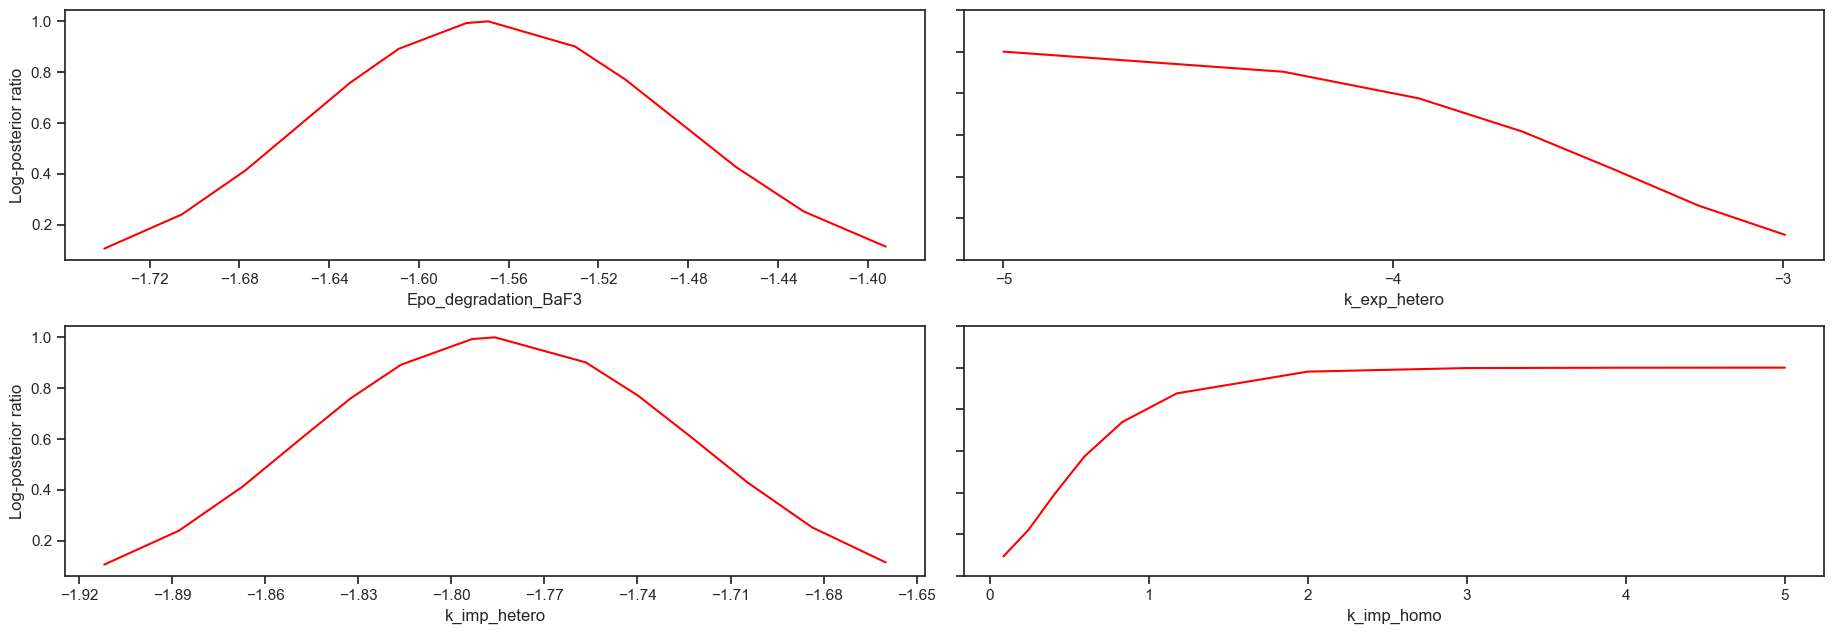

In [35]:
# plot profiles
pypesto.visualize.profiles(result);

## Sampling

We can use MCMC sampling to get a distribution on the posterior of the parameters. Here again, we do not need a lot of setup. We only need to define a sampler, of which pyPESTO offers a multitude.

In [36]:
# Sampling
sampler = sample.AdaptiveMetropolisSampler()
result = sample.sample(
    problem=problem,
    sampler=sampler,
    n_samples=10000,
    result=result,
)

100%|██████████| 10000/10000 [00:35<00:00, 282.68it/s]
Elapsed time: 43.299331


For visualization purposes, we can visualize the trace of the objective function value, as well as a scatter plot of the parameters, just like in the optimization. We do omit the scatter plot here, as it has a very large size.

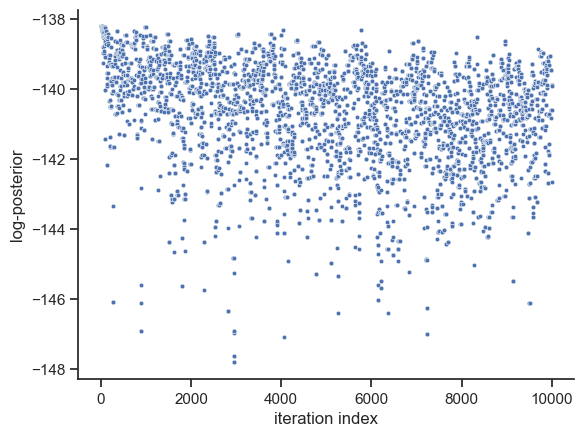

In [37]:
# plot objective function trace
visualize.sampling_fval_traces(result);

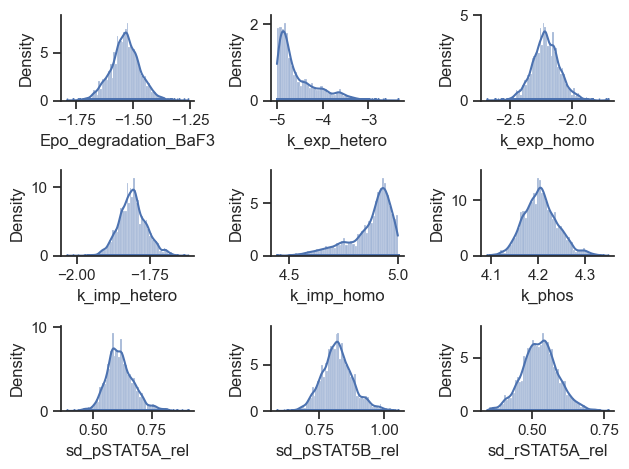

In [38]:
visualize.sampling_1d_marginals(result);

# Saving results

Lastly, the whole process took quite some time, but is not necessarily finished. It is therefore very useful, to be able to save the result as is. pyPESTO uses the hdf5 Format and with two very short commands we are able to read and write a result from and to an hdf5 file.

## Save result object in HDF5 File

In [39]:
# create temporary file
fn = tempfile.mktemp(".h5")

# write result with write_result function.
# Choose which parts of the result object to save with
# corresponding booleans.
store.write_result(
    result=result,
    filename=fn,
    problem=True,
    optimize=True,
    sample=True,
    profile=True,
)

## Reload results

In [40]:
# Read result
result2 = store.read_result(fn, problem=True)

This problem is not to be used without a separately created objective.


As the warning already suggests, we need to assign the problem again correctly.

In [41]:
result2.problem = problem

Now we are able to quickly load the result and visualize them.

## Plot (reloaded) results

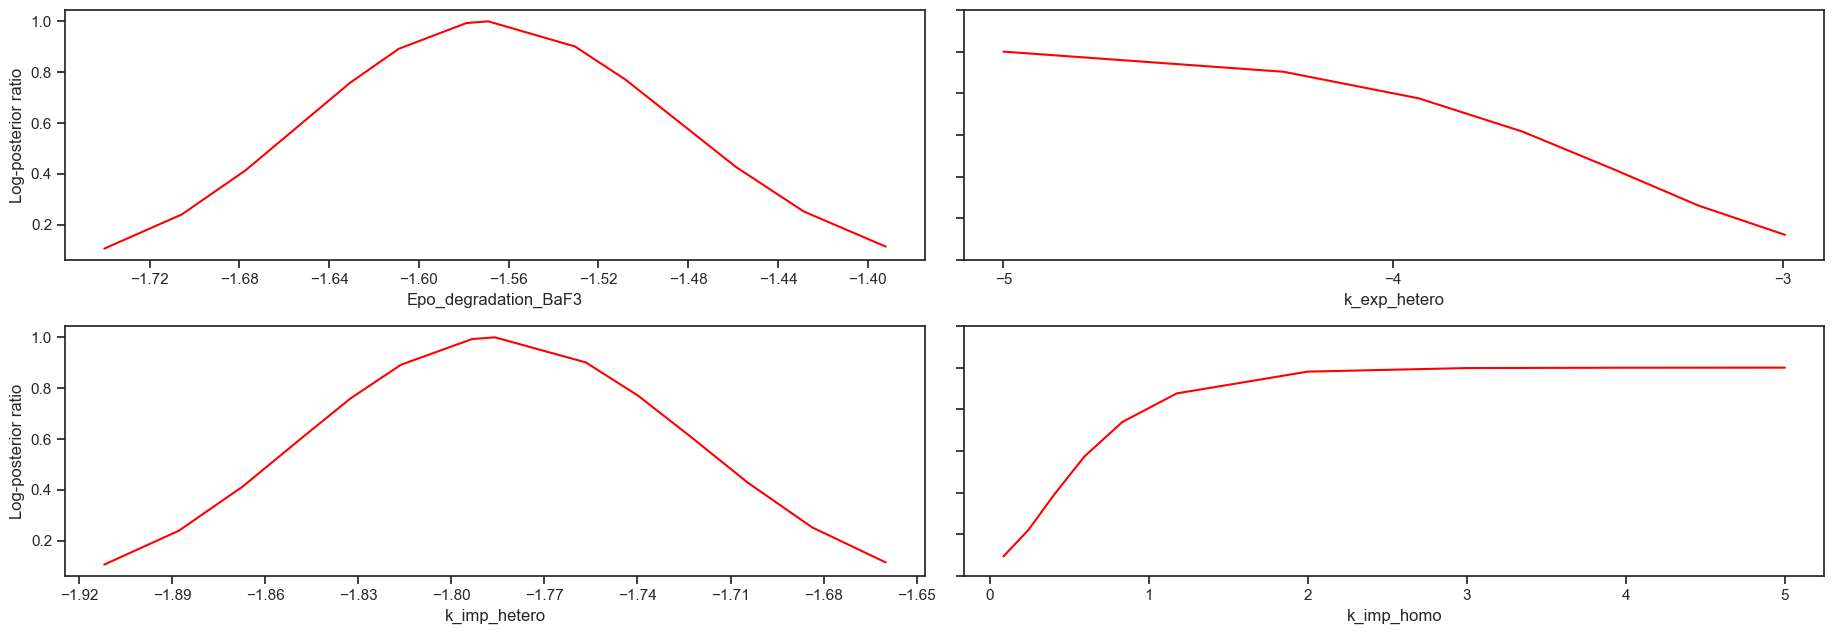

In [42]:
# plot profiles
pypesto.visualize.profiles(result2);